In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
dfs_our = []
for entry in os.scandir('C:\\Users\\Andrew/results_LGBT'):
    df = pd.read_csv(entry.path, header=None, sep='\n')
    df = df[0].str.split(',', expand=True)
    df.to_csv("Test.tab",sep="\t",header=False,index=False)
    a=df.iloc[1][4]
    b=df.iloc[1][3]
    df.columns = df.iloc[2]
    df.drop(labels = [0, 1, 2],axis = 0, inplace = True)
    df['gender']=a
    df['age']=b
    dfs_our.append(df)
df_our = pd.concat(dfs_our)

print(df_our.shape)
df_our.head()

(115290, 25)


2,rowNo,type,condition1,trialNo,stim1,topLeft,topRight,key,ITI,stimFormat,...,fixation,ITI_ms,ITI_f,ITI_fDuration,timestamp,response,RT,correct,gender,age
3,7,test,"""""","""4""",традиционная ориентация,гетеросексуал,гомосексуал,"""1""","""800""",word,...,"""1""",800,48,"""16.67""",43241,"""1""",2223,"""1""",male,"""22"""
4,5,test,"""""","""2""",гетеросексуал,гетеросексуал,гомосексуал,"""1""","""800""",word,...,"""1""",800,48,"""16.67""",45543,"""1""",1511,"""1""",male,"""22"""
5,8,test,"""""","""5""",Гетеросексуальность,гетеросексуал,гомосексуал,"""1""","""800""",word,...,"""1""",800,48,"""16.67""",47531,"""1""",1199,"""1""",male,"""22"""
6,12,test,"""""","""9""",ЛГБТ,гетеросексуал,гомосексуал,"""0""","""800""",word,...,"""1""",800,48,"""16.66""",49071,"""0""",740,"""1""",male,"""22"""
7,13,test,"""""","""10""",гомосексуалист,гетеросексуал,гомосексуал,"""0""","""800""",word,...,"""1""",800,48,"""16.67""",50758,"""0""",893,"""1""",male,"""22"""


In [4]:
df=df_our

df['RT'] = df['RT'].apply(pd.to_numeric, downcast='float', errors='coerce')

b=list(df['age'])
d=[]
for i in b:
    i=i[1:3]
    d.append(i)
d =  list(map(int, d))
se = pd.Series(d)
df['age_new'] = se.values
df

d=[]
b=list(df_our['correct'])
for i in b:
    i=i[1:2]
    d.append(i)
d =  list(map(int, d))
se = pd.Series(d)
df['correct_new'] = se.values
df

df=df[df['correct_new']==1]

df=df[(df['condition1']=='congruent')|(df['condition1']=='incongruent')]

df.loc[(df.gender == 'man'), 'gender'] = 'male'
df.loc[(df.gender == 'woman'), 'gender'] = 'female'

def change_1(row):
    if row <= 29:
        a = 'less than 29'
    if (row >29) and (row <= 49):
        a = 'from 30 to 49'
    if row > 49:
        a = 'more than 50'
    return a

df['age_new2']=df['age_new'].apply(change_1)

### Vizualization

In [6]:
df=df[['condition1', 'RT', 'age_new2', 'gender']]

df

2,condition1,RT,age_new2,gender
23,congruent,3943.0,less than 29,male
24,congruent,1086.0,less than 29,male
25,congruent,634.0,less than 29,male
27,congruent,1415.0,less than 29,male
28,congruent,1128.0,less than 29,male
...,...,...,...,...
68,incongruent,1774.0,more than 50,male
69,incongruent,1289.0,more than 50,male
70,incongruent,2189.0,more than 50,male
71,incongruent,1540.0,more than 50,male


**T-test**

In [8]:
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import t
import pandas as pd

def welch_ttest(x1, x2,alternative):
    
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    
    pooled_se = np.sqrt(v1 / n1 + v2 / n2)
    delta = m1-m2
    
    tstat = delta /  pooled_se
    df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    
    # two side t-test
    p = 2 * t.cdf(-abs(tstat), df)
    
    # upper and lower bounds
    lb = delta - t.ppf(0.975,df)*pooled_se 
    ub = delta + t.ppf(0.975,df)*pooled_se
  
    return pd.DataFrame(np.array([tstat,df,p,delta,lb,ub]).reshape(1,-1),
                         columns=['T statistic','df','pvalue 2 sided','Difference in mean','lb','ub'])

In [9]:
welch_ttest(ts1,ts2,"equal")

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,-1.832542,17.90031,0.08356,-1.0,-2.14691,0.14691


In [10]:
df_congruent = df[df['condition1'] == "congruent"]
df_incongruent = df[df['condition1'] == "incongruent"]

ts1 = np.array(df_congruent['RT'])
ts2 = np.array(df_incongruent['RT'])

welch_ttest(ts1,ts2,"equal")

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,-10.394035,54934.75224,2.785965e-25,-375.124131,-445.861431,-304.386831


In [11]:
import numpy as np
import scipy.stats as st

# returns confidence interval of mean
def confIntMean(a, conf=0.95):
    mean, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
    return mean - m*sem, mean + m*sem

In [13]:
confIntMean(ts1, 0.95)

(1414.2229975122868, 1523.79285869057)

In [14]:
np.mean(ts1)

1469.0079281014284

In [15]:
confIntMean(ts2, 0.95)

(1799.3817385276038, 1888.8823794861091)

In [16]:
np.mean(ts2)

1844.1320590068565

In [17]:
df_men_29 = df[(df['gender'] == 'male') & (df['age_new2'] == 'less than 29')]
df_men_3049 = df[(df['gender'] == 'male') & (df['age_new2'] == 'from 30 to 49')]
df_men_50 = df[(df['gender'] == 'male') & (df['age_new2'] == 'more than 50')]

df_women_29 = df[(df['gender'] == 'female') & (df['age_new2'] == 'less than 29')]
df_women_3049 = df[(df['gender'] == 'female') & (df['age_new2'] == 'from 30 to 49')]
df_women_50 = df[(df['gender'] == 'female') & (df['age_new2'] == 'more than 50')]

In [18]:
df_congruent = df_women_50[df_women_50['condition1'] == "congruent"]
df_incongruent = df_women_50[df_women_50['condition1'] == "incongruent"]

ts1 = np.array(df_congruent['RT'])
ts2 = np.array(df_incongruent['RT'])

print(confIntMean(ts1, 0.95))
print(confIntMean(ts2, 0.95))

(1421.3366437911673, 1950.9525458610515)
(1817.6771891554, 1931.5515779678876)


In [19]:
welch_ttest(ts1,ts2,"equal")

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,-1.364069,6369.860573,0.172594,-188.469789,-459.324172,82.384594


In [20]:
data1 = list(df_congruent['RT'])
data2 = list(df_incongruent['RT'])

stat, p = ttest_ind(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=-1.193, p=0.233
Probably the same distribution


In [ ]:
,,55450005

Text(0.5, 1.0, 'Women 50+')

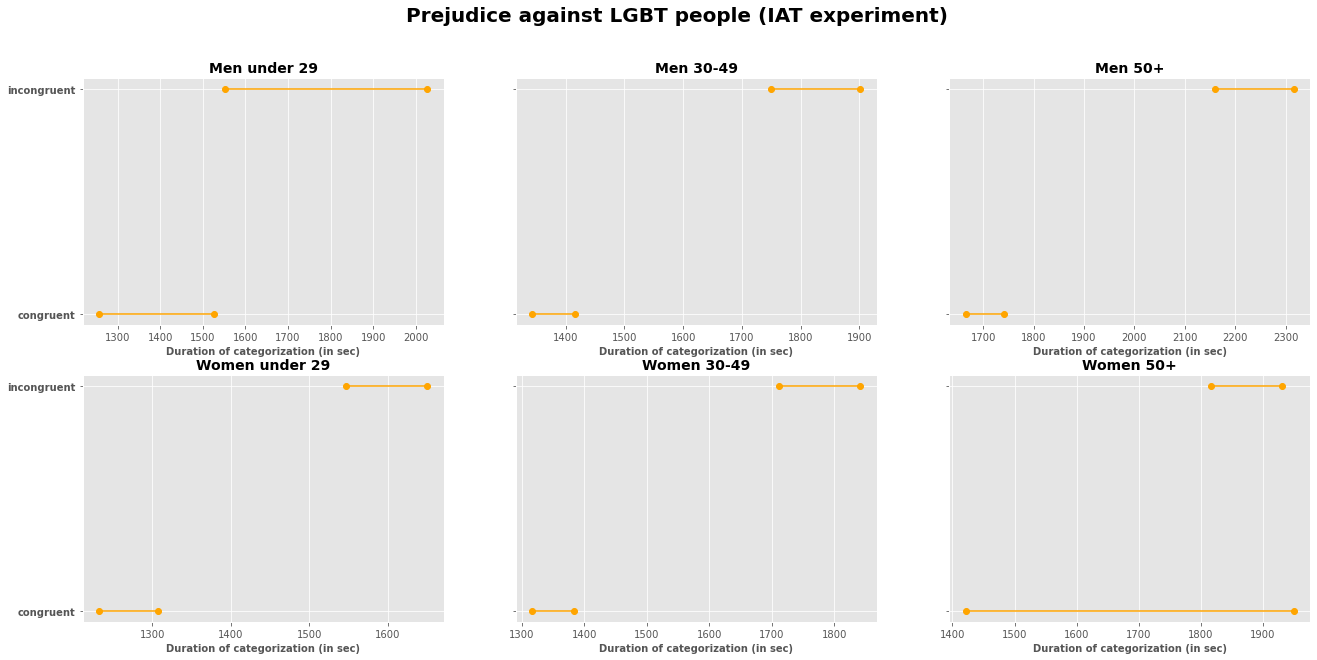

In [31]:
import pylab
from matplotlib import pyplot as plt

plt.style.use('ggplot')

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(
    nrows=2, ncols=3,
    figsize=(22, 10)
)

fig.suptitle('Prejudice against LGBT people (IAT experiment)', fontsize=20, fontweight="bold")

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1256,1552]
data_dict['upper'] = [1526,2027]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax1.plot((lower,upper),(y,y),'ro-',color='orange')
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['congruent','incongruent'], fontweight="bold")

ax1.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax1.set_title(
    'Men under 29',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1343,1749]
data_dict['upper'] = [1416,1902]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax2.plot((lower,upper),(y,y),'ro-',color='orange')
ax2.set_yticks([0, 1])
ax2.set_yticklabels([' ',' '], fontweight="bold")

ax2.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax2.set_title(
    'Men 30-49',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1665,2160]
data_dict['upper'] = [1742,2316]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax3.plot((lower,upper),(y,y),'ro-',color='orange')
ax3.set_yticks([0, 1])
ax3.set_yticklabels([' ',' '], fontweight="bold")

ax3.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax3.set_title(
    'Men 50+',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1232,1546]
data_dict['upper'] = [1307,1650]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax4.plot((lower,upper),(y,y),'ro-',color='orange')
ax4.set_yticks([0, 1])
ax4.set_yticklabels(['congruent','incongruent'], fontweight="bold")

ax4.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax4.set_title(
    'Women under 29',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1317,1712]
data_dict['upper'] = [1383,1842]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax5.plot((lower,upper),(y,y),'ro-',color='orange')
ax5.set_yticks([0, 1])
ax5.set_yticklabels([' ',' '], fontweight="bold")

ax5.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax5.set_title(
    'Women 30-49',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1421,1817]
data_dict['upper'] = [1950,1931]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax6.plot((lower,upper),(y,y),'ro-',color='orange')
ax6.set_yticks([0, 1])
ax6.set_yticklabels([' ',' '], fontweight="bold")

ax6.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax6.set_title(
    'Women 50+',
    fontsize=14, fontweight="bold"
)

## Sexism 

In [32]:
dfs_our = []
for entry in os.scandir('C:\\Users\\Andrew/results_sexism'):
    df = pd.read_csv(entry.path, header=None, sep='\n')
    df = df[0].str.split(',', expand=True)
    df.to_csv("Test.tab",sep="\t",header=False,index=False)
    a=df.iloc[1][4]
    b=df.iloc[1][3]
    df.columns = df.iloc[2]
    df.drop(labels = [0, 1, 2],axis = 0, inplace = True)
    df['gender']=a
    df['age']=b
    dfs_our.append(df)
df_our = pd.concat(dfs_our)

print(df_our.shape)
df_our.head()

(109270, 25)


2,rowNo,type,condition1,trialNo,stim1,topLeft,topRight,key,ITI,stimFormat,...,fixation,ITI_ms,ITI_f,ITI_fDuration,timestamp,response,RT,correct,gender,age
3,4,test,"""""","""1""",практичность,Политик,Домохозяйка,"""1""","""800""",word,...,"""1""",800,48,"""16.67""",30849,"""1""",1414,"""1""",male,"""23"""
4,7,test,"""""","""4""",власть,Политик,Домохозяйка,"""1""","""800""",word,...,"""1""",800,48,"""16.67""",32430,"""1""",780,"""1""",male,"""23"""
5,10,test,"""""","""7""",уборка,Политик,Домохозяйка,"""0""","""800""",word,...,"""1""",800,48,"""16.67""",33834,"""0""",601,"""1""",male,"""23"""
6,9,test,"""""","""6""",кулинария,Политик,Домохозяйка,"""0""","""800""",word,...,"""1""",800,48,"""16.67""",35231,"""0""",598,"""1""",male,"""23"""
7,13,test,"""""","""10""",воспитание детей,Политик,Домохозяйка,"""0""","""800""",word,...,"""1""",800,48,"""16.67""",36687,"""0""",654,"""1""",male,"""23"""


In [33]:
df=df_our
df['RT'] = df['RT'].apply(pd.to_numeric, downcast='float', errors='coerce')

b=list(df['age'])
d=[]
for i in b:
    i=i[1:3]
    d.append(i)
d =  list(map(int, d))
se = pd.Series(d)
df['age_new'] = se.values

d=[]
b=list(df_our['correct'])
for i in b:
    i=i[1:2]
    d.append(i)
d =  list(map(int, d))
se = pd.Series(d)
df['correct_new'] = se.values
df

2,rowNo,type,condition1,trialNo,stim1,topLeft,topRight,key,ITI,stimFormat,...,ITI_f,ITI_fDuration,timestamp,response,RT,correct,gender,age,age_new,correct_new
3,4,test,"""""","""1""",практичность,Политик,Домохозяйка,"""1""","""800""",word,...,48,"""16.67""",30849,"""1""",1414.0,"""1""",male,"""23""",23,1
4,7,test,"""""","""4""",власть,Политик,Домохозяйка,"""1""","""800""",word,...,48,"""16.67""",32430,"""1""",780.0,"""1""",male,"""23""",23,1
5,10,test,"""""","""7""",уборка,Политик,Домохозяйка,"""0""","""800""",word,...,48,"""16.67""",33834,"""0""",601.0,"""1""",male,"""23""",23,1
6,9,test,"""""","""6""",кулинария,Политик,Домохозяйка,"""0""","""800""",word,...,48,"""16.67""",35231,"""0""",598.0,"""1""",male,"""23""",23,1
7,13,test,"""""","""10""",воспитание детей,Политик,Домохозяйка,"""0""","""800""",word,...,48,"""16.67""",36687,"""0""",654.0,"""1""",male,"""23""",23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,66,test,incongruent,"""9""",Сергей,Женщина<br>ИЛИ<br>Политик,Мужчина<br>ИЛИ<br>Дохозяин,"""0""","""800""",word,...,48,"""16.67""",248614,"""0""",5264.0,"""1""",man,"""65""",65,1
69,73,test,incongruent,"""16""",кулинария,Женщина<br>ИЛИ<br>Политик,Мужчина<br>ИЛИ<br>Дохозяин,"""0""","""800""",word,...,48,"""16.67""",256270,"""0""",6852.0,"""1""",man,"""65""",65,1
70,62,test,incongruent,"""5""",Варвара,Женщина<br>ИЛИ<br>Политик,Мужчина<br>ИЛИ<br>Дохозяин,"""1""","""800""",word,...,48,"""16.67""",259446,"""1""",2376.0,"""1""",man,"""65""",65,1
71,58,test,incongruent,"""1""",Анастасия,Женщина<br>ИЛИ<br>Политик,Мужчина<br>ИЛИ<br>Дохозяин,"""1""","""800""",word,...,48,"""16.67""",262718,"""1""",2464.0,"""1""",man,"""65""",65,1


In [34]:
df=df[df['correct_new']==1]

df=df[(df['condition1']=='congruent')|(df['condition1']=='incongruent')]

df.loc[(df.gender == 'man'), 'gender'] = 'male'
df.loc[(df.gender == 'woman'), 'gender'] = 'female'

def change_1(row):
    if row <= 29:
        a = 'less than 29'
    if (row >29) and (row <= 49):
        a = 'from 30 to 49'
    if row > 49:
        a = 'more than 50'
    return a

df['age_new2']=df['age_new'].apply(change_1)

In [35]:
df_congruent=df[df['condition1'] == 'congruent' ]
print('average duration of congruent responses:', df_congruent['RT'].mean())

df_incongruent=df[df['condition1'] == 'incongruent' ]
print('average duration of incongruent responses:', df_incongruent['RT'].mean())


average duration of congruent responses: 1110.4517921086979
average duration of incongruent responses: 1453.2013514600596


In [36]:
df=df[['condition1', 'RT', 'age_new2', 'gender']]

In [37]:
df_congruent = df[df['condition1'] == "congruent"]
df_incongruent = df[df['condition1'] == "incongruent"]

ts1 = np.array(df_congruent['RT'])
ts2 = np.array(df_incongruent['RT'])

welch_ttest(ts1,ts2,"equal")

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,-14.961909,46374.211377,1.708932e-50,-342.749559,-387.649868,-297.849251


In [38]:
df_men_29 = df[(df['gender'] == 'male') & (df['age_new2'] == 'less than 29')]
df_men_3049 = df[(df['gender'] == 'male') & (df['age_new2'] == 'from 30 to 49')]
df_men_50 = df[(df['gender'] == 'male') & (df['age_new2'] == 'more than 50')]

df_women_29 = df[(df['gender'] == 'female') & (df['age_new2'] == 'less than 29')]
df_women_3049 = df[(df['gender'] == 'female') & (df['age_new2'] == 'from 30 to 49')]
df_women_50 = df[(df['gender'] == 'female') & (df['age_new2'] == 'more than 50')]

In [39]:
df_congruent = df_women_50[df_women_50['condition1'] == "congruent"]
df_incongruent = df_women_50[df_women_50['condition1'] == "incongruent"]

ts1 = np.array(df_congruent['RT'])
ts2 = np.array(df_incongruent['RT'])

print(confIntMean(ts1, 0.95))
print(confIntMean(ts2, 0.95))

(1122.5637192284062, 1173.5163773705071)
(1444.2526855543788, 1529.712226726323)


In [40]:
welch_ttest(ts1,ts2,"equal")

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,-13.357366,6740.402985,3.468388e-40,-338.942408,-388.685314,-289.199501


In [41]:
data1 = list(df_congruent['RT'])
data2 = list(df_incongruent['RT'])

stat, p = ttest_ind(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=-13.904, p=0.000
Probably different distributions


Text(0.5, 1.0, 'Women 50+')

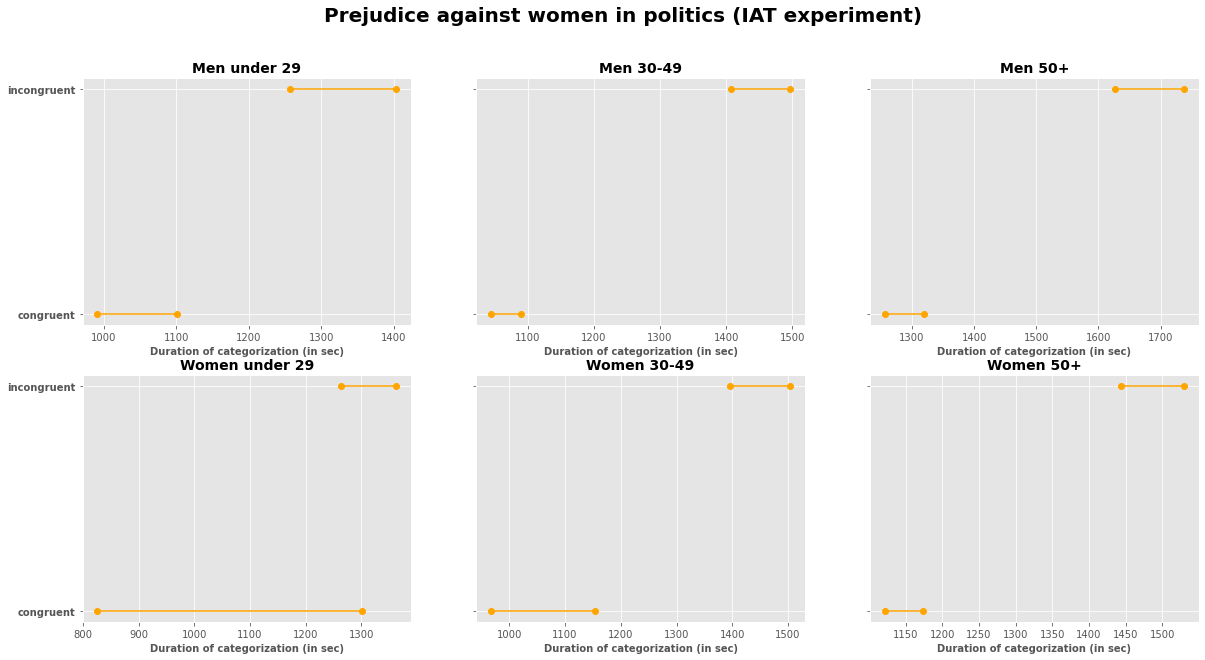

In [42]:
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(
    nrows=2, ncols=3,
    figsize=(20, 10)
)

fig.suptitle('Prejudice against women in politics (IAT experiment)', fontsize=20, fontweight="bold")

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [991,1257]
data_dict['upper'] = [1101,1403]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax1.plot((lower,upper),(y,y),'ro-',color='orange')
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['congruent','incongruent'], fontweight="bold")

ax1.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax1.set_title(
    'Men under 29',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1045,1407]
data_dict['upper'] = [1090,1496]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax2.plot((lower,upper),(y,y),'ro-',color='orange')
ax2.set_yticks([0, 1])
ax2.set_yticklabels([' ',' '], fontweight="bold")

ax2.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax2.set_title(
    'Men 30-49',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1257,1627]
data_dict['upper'] = [1320,1737]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax3.plot((lower,upper),(y,y),'ro-',color='orange')
ax3.set_yticks([0, 1])
ax3.set_yticklabels([' ',' '], fontweight="bold")

ax3.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax3.set_title(
    'Men 50+',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [826,1264]
data_dict['upper'] = [1302,1362]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax4.plot((lower,upper),(y,y),'ro-',color='orange')
ax4.set_yticks([0, 1])
ax4.set_yticklabels(['congruent','incongruent'], fontweight="bold")

ax4.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax4.set_title(
    'Women under 29',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [968,1396]
data_dict['upper'] = [1153,1503]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax5.plot((lower,upper),(y,y),'ro-',color='orange')
ax5.set_yticks([0, 1])
ax5.set_yticklabels([' ',' '], fontweight="bold")

ax5.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax5.set_title(
    'Women 30-49',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1122,1444]
data_dict['upper'] = [1173,1529]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax6.plot((lower,upper),(y,y),'ro-',color='orange')
ax6.set_yticks([0, 1])
ax6.set_yticklabels([' ',' '], fontweight="bold")

ax6.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax6.set_title(
    'Women 50+',
    fontsize=14, fontweight="bold"
)

## Xenofobia

In [43]:
dfs_our = []
for entry in os.scandir('C:\\Users\\Andrew/results_xenofobia'):
    df = pd.read_csv(entry.path, header=None, sep='\n')
    df = df[0].str.split(',', expand=True)
    df.to_csv("Test.tab",sep="\t",header=False,index=False)
    a=df.iloc[1][4]
    b=df.iloc[1][3]
    df.columns = df.iloc[2]
    df.drop(labels = [0, 1, 2],axis = 0, inplace = True)
    df['gender']=a
    df['age']=b
    dfs_our.append(df)
df_our = pd.concat(dfs_our)

print(df_our.shape)
df_our.head()

(107520, 25)


2,rowNo,type,condition1,trialNo,stim1,topLeft,topRight,key,ITI,stimFormat,...,fixation,ITI_ms,ITI_f,ITI_fDuration,timestamp,response,RT,correct,gender,age
3,8,test,"""""","""5""",Прекрасный,Хорошее,Плохое,"""1""","""800""",word,...,"""1""",800,48,"""16.67""",25060,"""1""",1332,"""1""",male,"""23"""
4,11,test,"""""","""8""",Злой,Хорошее,Плохое,"""0""","""800""",word,...,"""1""",800,48,"""16.67""",26595,"""0""",736,"""1""",male,"""23"""
5,6,test,"""""","""3""",Дружба,Хорошее,Плохое,"""1""","""800""",word,...,"""1""",800,48,"""16.67""",27870,"""1""",477,"""1""",male,"""23"""
6,4,test,"""""","""1""",Радость,Хорошее,Плохое,"""1""","""800""",word,...,"""1""",800,48,"""16.67""",29331,"""0""",672,"""0""",male,"""23"""
7,10,test,"""""","""7""",Грязный,Хорошее,Плохое,"""0""","""800""",word,...,"""1""",800,48,"""16.67""",31957,"""0""",831,"""1""",male,"""23"""


In [44]:
df=df_our
df['RT'] = df['RT'].apply(pd.to_numeric, downcast='float', errors='coerce')

b=list(df['age'])
d=[]
for i in b:
    i=i[1:3]
    d.append(i)
d =  list(map(int, d))
se = pd.Series(d)
df['age_new'] = se.values

d=[]
b=list(df_our['correct'])
for i in b:
    i=i[1:2]
    d.append(i)
d =  list(map(int, d))
se = pd.Series(d)
df['correct_new'] = se.values
df

2,rowNo,type,condition1,trialNo,stim1,topLeft,topRight,key,ITI,stimFormat,...,ITI_f,ITI_fDuration,timestamp,response,RT,correct,gender,age,age_new,correct_new
3,8,test,"""""","""5""",Прекрасный,Хорошее,Плохое,"""1""","""800""",word,...,48,"""16.67""",25060,"""1""",1332.0,"""1""",male,"""23""",23,1
4,11,test,"""""","""8""",Злой,Хорошее,Плохое,"""0""","""800""",word,...,48,"""16.67""",26595,"""0""",736.0,"""1""",male,"""23""",23,1
5,6,test,"""""","""3""",Дружба,Хорошее,Плохое,"""1""","""800""",word,...,48,"""16.67""",27870,"""1""",477.0,"""1""",male,"""23""",23,1
6,4,test,"""""","""1""",Радость,Хорошее,Плохое,"""1""","""800""",word,...,48,"""16.67""",29331,"""0""",672.0,"""0""",male,"""23""",23,0
7,10,test,"""""","""7""",Грязный,Хорошее,Плохое,"""0""","""800""",word,...,48,"""16.67""",31957,"""0""",831.0,"""1""",male,"""23""",23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,62,test,incongruent,"""5""",Фатхулла,Иностранец<br>ИЛИ<br>Хорошее,Местный<br>ИЛИ<br>Плохое,"""1""","""800""",word,...,48,"""16.67""",198794,"""1""",1078.0,"""1""",man,"""65""",65,1
69,72,test,incongruent,"""15""",Прекрасный,Иностранец<br>ИЛИ<br>Хорошее,Местный<br>ИЛИ<br>Плохое,"""1""","""800""",word,...,48,"""16.67""",203371,"""0""",3770.0,"""0""",man,"""65""",65,0
70,77,test,incongruent,"""20""",Опасность,Иностранец<br>ИЛИ<br>Хорошее,Местный<br>ИЛИ<br>Плохое,"""0""","""800""",word,...,48,"""16.67""",208658,"""0""",4473.0,"""1""",man,"""65""",65,1
71,65,test,incongruent,"""8""",Пётр,Иностранец<br>ИЛИ<br>Хорошее,Местный<br>ИЛИ<br>Плохое,"""0""","""800""",word,...,48,"""16.67""",211898,"""0""",2444.0,"""1""",man,"""65""",65,1


In [45]:
df=df[df['correct_new']==1]

df=df[(df['condition1']=='congruent')|(df['condition1']=='incongruent')]

df.loc[(df.gender == 'man'), 'gender'] = 'male'
df.loc[(df.gender == 'woman'), 'gender'] = 'female'

def change_1(row):
    if row <= 29:
        a = 'less than 29'
    if (row >29) and (row <= 49):
        a = 'from 30 to 49'
    if row > 49:
        a = 'more than 50'
    return a

df['age_new2']=df['age_new'].apply(change_1)

In [46]:
df_congruent=df[df['condition1'] == 'congruent' ]
print('average duration of congruent responses:', df_congruent['RT'].mean())

df_incongruent=df[df['condition1'] == 'incongruent' ]
print('average duration of incongruent responses:', df_incongruent['RT'].mean())

average duration of congruent responses: 1093.7741118465487
average duration of incongruent responses: 1497.024167789109


In [47]:
df=df[['condition1', 'RT', 'age_new2', 'gender']]

In [48]:
df_men_29 = df[(df['gender'] == 'male') & (df['age_new2'] == 'less than 29')]
df_men_3049 = df[(df['gender'] == 'male') & (df['age_new2'] == 'from 30 to 49')]
df_men_50 = df[(df['gender'] == 'male') & (df['age_new2'] == 'more than 50')]

df_women_29 = df[(df['gender'] == 'female') & (df['age_new2'] == 'less than 29')]
df_women_3049 = df[(df['gender'] == 'female') & (df['age_new2'] == 'from 30 to 49')]
df_women_50 = df[(df['gender'] == 'female') & (df['age_new2'] == 'more than 50')]

In [49]:
df_congruent = df_women_50[df_women_50['condition1'] == "congruent"]
df_incongruent = df_women_50[df_women_50['condition1'] == "incongruent"]

ts1 = np.array(df_congruent['RT'])
ts2 = np.array(df_incongruent['RT'])

print(confIntMean(ts1, 0.95))
print(confIntMean(ts2, 0.95))

(1103.990801553033, 1159.9718617948204)
(1474.7963907179515, 1559.1804320729707)


In [50]:
welch_ttest(ts1,ts2,"equal")

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,-14.907681,7363.036036,1.543232e-49,-385.00708,-435.633605,-334.380555


In [51]:
data1 = list(df_congruent['RT'])
data2 = list(df_incongruent['RT'])

stat, p = ttest_ind(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=-15.276, p=0.000
Probably different distributions


Text(0.5, 1.0, 'Women 50+')

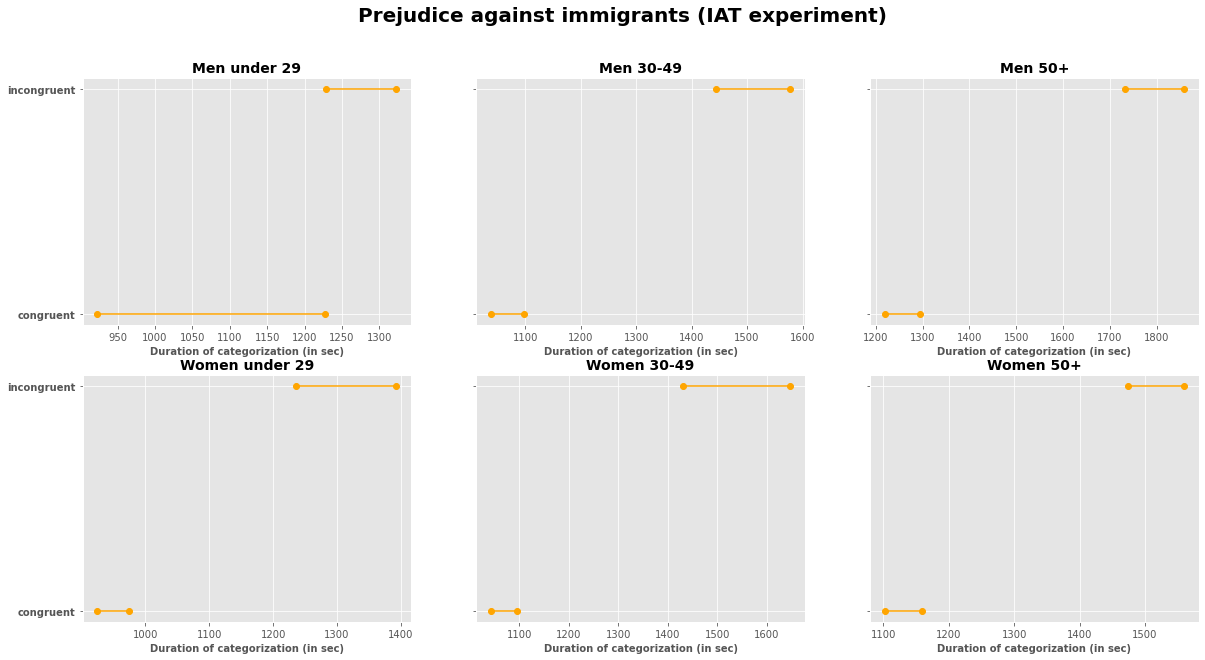

In [52]:
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(
    nrows=2, ncols=3,
    figsize=(20, 10)
)

fig.suptitle('Prejudice against immigrants (IAT experiment)', fontsize=20, fontweight="bold")

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [923,1228]
data_dict['upper'] = [1227,1322]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax1.plot((lower,upper),(y,y),'ro-',color='orange')
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['congruent','incongruent'], fontweight="bold")

ax1.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax1.set_title(
    'Men under 29',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1039,1444]
data_dict['upper'] = [1097,1577]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax2.plot((lower,upper),(y,y),'ro-',color='orange')
ax2.set_yticks([0, 1])
ax2.set_yticklabels([' ',' '], fontweight="bold")

ax2.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax2.set_title(
    'Men 30-49',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1220,1732]
data_dict['upper'] = [1295,1858]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax3.plot((lower,upper),(y,y),'ro-',color='orange')
ax3.set_yticks([0, 1])
ax3.set_yticklabels([' ',' '], fontweight="bold")

ax3.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax3.set_title(
    'Men 50+',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [925,1236]
data_dict['upper'] = [974,1392]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax4.plot((lower,upper),(y,y),'ro-',color='orange')
ax4.set_yticks([0, 1])
ax4.set_yticklabels(['congruent','incongruent'], fontweight="bold")

ax4.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax4.set_title(
    'Women under 29',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1044,1430]
data_dict['upper'] = [1096,1646]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax5.plot((lower,upper),(y,y),'ro-',color='orange')
ax5.set_yticks([0, 1])
ax5.set_yticklabels([' ',' '], fontweight="bold")

ax5.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax5.set_title(
    'Women 30-49',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1103,1474]
data_dict['upper'] = [1159,1559]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax6.plot((lower,upper),(y,y),'ro-',color='orange')
ax6.set_yticks([0, 1])
ax6.set_yticklabels([' ',' '], fontweight="bold")

ax6.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax6.set_title(
    'Women 50+',
    fontsize=14, fontweight="bold"
)

## Opposition sentiment

In [53]:
dfs_our = []
for entry in os.scandir('C:\\Users\\Andrew/results_opposition'):
    df = pd.read_csv(entry.path, header=None, sep='\n')
    df = df[0].str.split(',', expand=True)
    df.to_csv("Test.tab",sep="\t",header=False,index=False)
    a=df.iloc[1][4]
    b=df.iloc[1][3]
    df.columns = df.iloc[2]
    df.drop(labels = [0, 1, 2],axis = 0, inplace = True)
    df['gender']=a
    df['age']=b
    dfs_our.append(df)
df_our = pd.concat(dfs_our)

print(df_our.shape)
df_our.head()

(107170, 25)


2,rowNo,type,condition1,trialNo,stim1,topLeft,topRight,key,ITI,stimFormat,...,fixation,ITI_ms,ITI_f,ITI_fDuration,timestamp,response,RT,correct,gender,age
3,4,test,"""""","""1""",Надёжность,Хорошее,Плохое,"""1""","""800""",word,...,"""1""",800,48,"""16.67""",25075,"""1""",1507,"""1""",man,"""23"""
4,12,test,"""""","""9""",Коррупция,Хорошее,Плохое,"""0""","""800""",word,...,"""1""",800,48,"""16.67""",26456,"""0""",589,"""1""",man,"""23"""
5,8,test,"""""","""5""",Отзывчивость,Хорошее,Плохое,"""1""","""800""",word,...,"""1""",800,48,"""16.67""",28194,"""1""",944,"""1""",man,"""23"""
6,7,test,"""""","""4""",Честность,Хорошее,Плохое,"""1""","""800""",word,...,"""1""",800,48,"""16.66""",29737,"""1""",754,"""1""",man,"""23"""
7,5,test,"""""","""2""",Защита,Хорошее,Плохое,"""1""","""800""",word,...,"""1""",800,48,"""16.66""",33073,"""1""",2540,"""1""",man,"""23"""


In [54]:
df=df_our
df['RT'] = df['RT'].apply(pd.to_numeric, downcast='float', errors='coerce')

b=list(df['age'])
d=[]
for i in b:
    i=i[1:3]
    d.append(i)
d =  list(map(int, d))
se = pd.Series(d)
df['age_new'] = se.values

d=[]
b=list(df_our['correct'])
for i in b:
    i=i[1:2]
    d.append(i)
d =  list(map(int, d))
se = pd.Series(d)
df['correct_new'] = se.values
df

2,rowNo,type,condition1,trialNo,stim1,topLeft,topRight,key,ITI,stimFormat,...,ITI_f,ITI_fDuration,timestamp,response,RT,correct,gender,age,age_new,correct_new
3,4,test,"""""","""1""",Надёжность,Хорошее,Плохое,"""1""","""800""",word,...,48,"""16.67""",25075,"""1""",1507.0,"""1""",man,"""23""",23,1
4,12,test,"""""","""9""",Коррупция,Хорошее,Плохое,"""0""","""800""",word,...,48,"""16.67""",26456,"""0""",589.0,"""1""",man,"""23""",23,1
5,8,test,"""""","""5""",Отзывчивость,Хорошее,Плохое,"""1""","""800""",word,...,48,"""16.67""",28194,"""1""",944.0,"""1""",man,"""23""",23,1
6,7,test,"""""","""4""",Честность,Хорошее,Плохое,"""1""","""800""",word,...,48,"""16.66""",29737,"""1""",754.0,"""1""",man,"""23""",23,1
7,5,test,"""""","""2""",Защита,Хорошее,Плохое,"""1""","""800""",word,...,48,"""16.66""",33073,"""1""",2540.0,"""1""",man,"""23""",23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,69,test,incongruent,"""12""",Защита,Оппозиция<br>ИЛИ<br>Хорошее,Власть<br>ИЛИ<br>Плохое,"""1""","""800""",word,...,48,"""16.67""",199142,"""1""",3300.0,"""1""",man,"""65""",65,1
69,67,test,incongruent,"""10""",Президент,Оппозиция<br>ИЛИ<br>Хорошее,Власть<br>ИЛИ<br>Плохое,"""0""","""800""",word,...,48,"""16.67""",201126,"""0""",1167.0,"""1""",man,"""65""",65,1
70,73,test,incongruent,"""16""",Предательство,Оппозиция<br>ИЛИ<br>Хорошее,Власть<br>ИЛИ<br>Плохое,"""0""","""800""",word,...,48,"""16.67""",205133,"""0""",3190.0,"""1""",man,"""65""",65,1
71,75,test,incongruent,"""18""",Измена,Оппозиция<br>ИЛИ<br>Хорошее,Власть<br>ИЛИ<br>Плохое,"""0""","""800""",word,...,48,"""16.67""",207214,"""0""",1283.0,"""1""",man,"""65""",65,1


In [55]:
df=df[df['correct_new']==1]

df=df[(df['condition1']=='congruent')|(df['condition1']=='incongruent')]

df.loc[(df.gender == 'man'), 'gender'] = 'male'
df.loc[(df.gender == 'woman'), 'gender'] = 'female'

def change_1(row):
    if row <= 29:
        a = 'less than 29'
    if (row >29) and (row <= 49):
        a = 'from 30 to 49'
    if row > 49:
        a = 'more than 50'
    return a

df['age_new2']=df['age_new'].apply(change_1)

In [56]:
df_congruent=df[df['condition1'] == 'congruent' ]
print('average duration of congruent responses:', df_congruent['RT'].mean())

df_incongruent=df[df['condition1'] == 'incongruent' ]
print('average duration of incongruent responses:', df_incongruent['RT'].mean())

average duration of congruent responses: 1331.7431303116148
average duration of incongruent responses: 1614.7935112673806


In [57]:
df=df[['condition1', 'RT', 'age_new2', 'gender']]

df_men_29 = df[(df['gender'] == 'male') & (df['age_new2'] == 'less than 29')]
df_men_3049 = df[(df['gender'] == 'male') & (df['age_new2'] == 'from 30 to 49')]
df_men_50 = df[(df['gender'] == 'male') & (df['age_new2'] == 'more than 50')]

df_women_29 = df[(df['gender'] == 'female') & (df['age_new2'] == 'less than 29')]
df_women_3049 = df[(df['gender'] == 'female') & (df['age_new2'] == 'from 30 to 49')]
df_women_50 = df[(df['gender'] == 'female') & (df['age_new2'] == 'more than 50')]

In [58]:
df_congruent = df_women_50[df_women_50['condition1'] == "congruent"]
df_incongruent = df_women_50[df_women_50['condition1'] == "incongruent"]

ts1 = np.array(df_congruent['RT'])
ts2 = np.array(df_incongruent['RT'])

print(confIntMean(ts1, 0.95))
print(confIntMean(ts2, 0.95))

(1277.3758692885879, 1351.1800206512228)
(1608.2565733003128, 1705.2072241680419)


In [59]:
welch_ttest(ts1,ts2,"equal")

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,-11.020321,7666.406995,4.947211e-28,-342.453954,-403.369001,-281.538906


In [60]:
data1 = list(df_congruent['RT'])
data2 = list(df_incongruent['RT'])

stat, p = ttest_ind(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=-11.191, p=0.000
Probably different distributions


Text(0.5, 1.0, 'Women 50+')

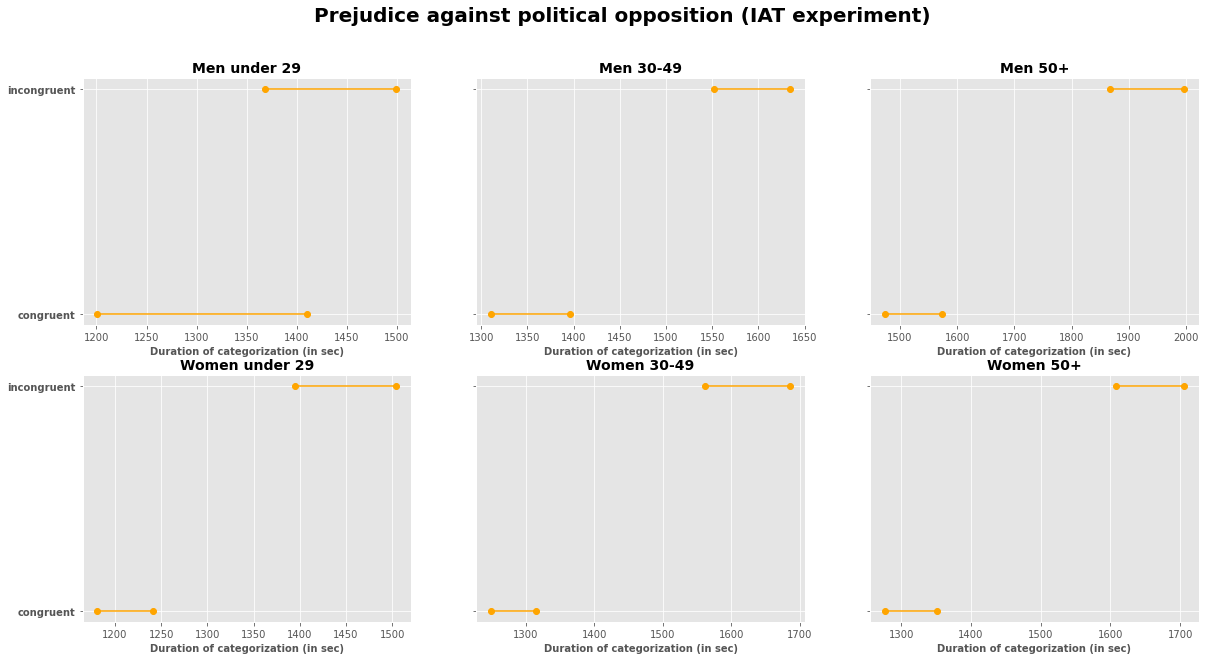

In [61]:
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(
    nrows=2, ncols=3,
    figsize=(20, 10)
)

fig.suptitle('Prejudice against political opposition (IAT experiment)', fontsize=20, fontweight="bold")

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1201,1368]
data_dict['upper'] = [1410,1499]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax1.plot((lower,upper),(y,y),'ro-',color='orange')
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['congruent','incongruent'], fontweight="bold")

ax1.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax1.set_title(
    'Men under 29',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1311,1552]
data_dict['upper'] = [1396,1634]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax2.plot((lower,upper),(y,y),'ro-',color='orange')
ax2.set_yticks([0, 1])
ax2.set_yticklabels([' ',' '], fontweight="bold")

ax2.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax2.set_title(
    'Men 30-49',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1474,1868]
data_dict['upper'] = [1574,1996]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax3.plot((lower,upper),(y,y),'ro-',color='orange')
ax3.set_yticks([0, 1])
ax3.set_yticklabels([' ',' '], fontweight="bold")

ax3.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax3.set_title(
    'Men 50+',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1181,1395]
data_dict['upper'] = [1241,1504]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax4.plot((lower,upper),(y,y),'ro-',color='orange')
ax4.set_yticks([0, 1])
ax4.set_yticklabels(['congruent','incongruent'], fontweight="bold")

ax4.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax4.set_title(
    'Women under 29',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1250,1561]
data_dict['upper'] = [1315,1685]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax5.plot((lower,upper),(y,y),'ro-',color='orange')
ax5.set_yticks([0, 1])
ax5.set_yticklabels([' ',' '], fontweight="bold")

ax5.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax5.set_title(
    'Women 30-49',
    fontsize=14, fontweight="bold"
)

data_dict = {}
data_dict['category'] = ['congruent','incongruent']
data_dict['lower'] = [1277,1608]
data_dict['upper'] = [1351,1705]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    ax6.plot((lower,upper),(y,y),'ro-',color='orange')
ax6.set_yticks([0, 1])
ax6.set_yticklabels([' ',' '], fontweight="bold")

ax6.set_xlabel("Duration of categorization (in sec)", fontsize=10, fontweight="bold")
ax6.set_title(
    'Women 50+',
    fontsize=14, fontweight="bold"
)